## Dropout is best !!!!111!1!1!

In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from fashion import FashionMNIST
import torch.utils.model_zoo as model_zoo
from collections import namedtuple

In [2]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d''Inception3', 
           'inception_v3',
           'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19',
           'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    # Inception v3 ported from TensorFlow
    'inception_v3_google': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
    # vgg with TensorFlow
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
    # ResNet with TensorFlow
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

_InceptionOuputs = namedtuple('InceptionOuputs', ['logits', 'aux_logits'])


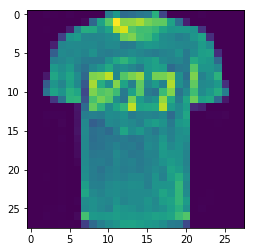

In [3]:
train_data = FashionMNIST('../data', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       #torchvision.transforms.Grayscale(3),
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = FashionMNIST('../data', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       #torchvision.transforms.Grayscale(3),
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ]))


train_idx = np.random.choice(train_data.data.shape[0], 54000, replace=False)

train_data.data = train_data.data[train_idx, :]
train_data.targets = train_data.targets[torch.from_numpy(train_idx).type(torch.LongTensor)]

mask = np.ones(60000)
mask[train_idx] = 0

valid_data.data = valid_data.data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.targets[torch.from_numpy(mask).type(torch.ByteTensor)]

batch_size = 100
test_batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    FashionMNIST('../data', train=False, transform=torchvision.transforms.Compose([
                       torchvision.transforms.Grayscale(3),
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

validation_data = {}
loss_train_data = {}
loss_validation_data = {}

plt.imshow(train_loader.dataset.data[1].numpy()) #Potentially printing out an image

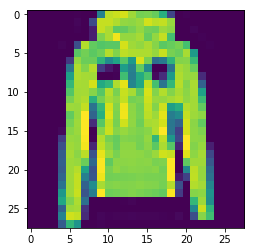

In [4]:
plt.imshow(train_loader.dataset.data[10].numpy()) # another image

#### Modèle 1: FCC sans dropout

In [5]:
class FccWithoutDropout(nn.Module):
    def __init__(self, model_id, input_size, hidden_sizes, output_size, activation_function):
        super().__init__()
        self.model_id = model_id
        self.activation_function = activation_function
        self.inputToHidden = nn.Linear(input_size, hidden_sizes[0]) #Linear(D, M)
        self.hiddenToHidden = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hiddenToHidden.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.hiddenToOutput = nn.Linear(hidden_sizes[len(hidden_sizes) - 1], output_size) #Linear(M, K)
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = self.activation_function(self.inputToHidden(x))
        for f in self.hiddenToHidden:
            x = self.activation_function(f(x))
        x = F.log_softmax(self.hiddenToOutput(x), dim=1)
        return x

#### Modèle 2: FCC avec dropout

In [6]:
class FccWithDropout(nn.Module):
    def __init__(self, model_id, input_size, hidden_sizes, output_size, activation_function, dropout):
        super().__init__()
        self.model_id = model_id
        self.activation_function = activation_function
        self.inputToHidden = nn.Linear(input_size, hidden_sizes[0]) #Linear(D, M)
        self.hiddenToHidden = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hiddenToHidden.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.hiddenToOutput = nn.Linear(hidden_sizes[len(hidden_sizes) - 1], output_size) #Linear(M, K)
        self.dropout = dropout
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = self.activation_function(self.dropout(self.inputToHidden(x)))
        for f in self.hiddenToHidden:
            x = self.activation_function(self.dropout(f(x)))
        x = F.log_softmax(self.dropout(self.hiddenToOutput(x)), dim=1)
        return x

#### Modèle 3: CNN sans dropout

In [7]:
class SimpleCnnWithoutDropout(nn.Module): #taken from https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/
    #Our batch shape for input x is (1, 28, 28)
    
    def __init__(self, model_id):
        super().__init__()
        self.model_id = model_id
        
        #Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 25, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(25 * 14 * 14, 256)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(256, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (1, 28, 28) to (25, 28, 28)
        x = F.relu(self.conv1(x))
        
        #Size changes from (25, 28, 28) to (25, 14, 14)
        x = self.pool(x)
       
        #Reshape data to input to the input layer of the neural net
        #Size changes from (25, 14, 14) to (1, 4900)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 25 * 14 *14)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4900) to (1, 256)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 256) to (1, 10)
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        return(x)

#### Modèle 4: CNN avec dropout

In [8]:
class SimpleCnnWithDropout(nn.Module): #taken from https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/
    #Our batch shape for input x is (1, 28, 28)
    
    def __init__(self, model_id, dropout):
        super().__init__()
        self.model_id = model_id
        self.dropout = dropout
        
        #Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 25, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(25 * 14 * 14, 256)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(256, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (1, 28, 28) to (25, 28, 28)
        x = F.relu(self.dropout(self.conv1(x)))
        
        #Size changes from (25, 28, 28) to (25, 14, 14)
        x = self.pool(x)
       
        #Reshape data to input to the input layer of the neural net
        #Size changes from (25, 14, 14) to (1, 4900)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 25 * 14 *14)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4900) to (1, 256)
        x = F.relu(self.dropout(self.fc1(x)))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 256) to (1, 10)
        x = self.fc2(x)
        x = F.log_softmax(self.dropout(x), dim = 1)
        return(x)

#### Modèles 5 et 6: VGG avec et sans dropout

In [9]:
class VGG(nn.Module):

    def __init__(self, features, model_id, dropout=True, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.model_id = model_id
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        if dropout:
            self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(4096, num_classes),
            )
        else :
            self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(True),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Linear(4096, num_classes),
            )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model


def vgg11_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn']))
    return model


def vgg13(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13']))
    return model


def vgg13_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13_bn']))
    return model


def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model


def vgg16_bn(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16_bn']))
    return model


def vgg19(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration "E")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model


def vgg19_bn(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
    return model

#### Modèles 7 et 8: Inception V3 avec et sans dropout

In [17]:
def inception_v3(pretrained=False, dropout=True, **kwargs):
    r"""Inception v3 model architecture from
    `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
    .. note::
        **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
        N x 3 x 299 x 299, so ensure your images are sized accordingly.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        aux_logits (bool): If True, add an auxiliary branch that can improve training.
            Default: *True*
        transform_input (bool): If True, preprocesses the input according to the method with which it
            was trained on ImageNet. Default: *False*
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        if 'aux_logits' in kwargs:
            original_aux_logits = kwargs['aux_logits']
            kwargs['aux_logits'] = True
        else:
            original_aux_logits = True
        model = Inception3(**kwargs)
        model.load_state_dict(model_zoo.load_url(model_urls['inception_v3_google']))
        if not original_aux_logits:
            model.aux_logits = False
            del model.AuxLogits
        return model
    if dropout:
        return Inception3WithDropout(**kwargs)
    else :
        return Inception3WithoutDropout(**kwargs)


class Inception3WithDropout(nn.Module):

    def __init__(self, model_id, num_classes=1000, aux_logits=True, transform_input=False):
        super(Inception3WithDropout, self).__init__()
        self.model_id = model_id
        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = BasicConv2d(1, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                X = stats.truncnorm(-2, 2, scale=stddev)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        # N x 1 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        if self.training and self.aux_logits:
            aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 2048 x 1 x 1
        x = F.dropout(x, training=self.training)
        # N x 2048 x 1 x 1
        x = x.view(x.size(0), -1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:
            return _InceptionOuputs(x, aux)
        return x

class Inception3WithoutDropout(nn.Module):

    def __init__(self, model_id, num_classes=1000, aux_logits=True, transform_input=False):
        super(Inception3WithoutDropout, self).__init__()
        self.model_id = model_id
        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = BasicConv2d(1, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                X = stats.truncnorm(-2, 2, scale=stddev)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        # N x 1 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        if self.training and self.aux_logits:
            aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 2048 x 1 x 1 This is the dropout line that needs to be commented out.
        #x = F.dropout(x, training=self.training)
        # N x 2048 x 1 x 1
        x = x.view(x.size(0), -1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:
            return _InceptionOuputs(x, aux)
        return x

class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):

    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):

    def __init__(self, in_channels):
        super(InceptionE, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = x.view(x.size(0), -1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

#### Modèles 9 et 10: Resnet avec et sans dropout

In [21]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlockWithDropout(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(BasicBlockWithDropout, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.dropout(out, training=self.training);
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.dropout(out, training=self.training);
        out = self.relu(out)

        return out

    
class BasicBlockWithoutDropout(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(BasicBlockWithoutDropout, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetWithDropout(nn.Module):

    def __init__(self, block, layers, model_id, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super(ResNetWithDropout, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        self.model_id = model_id

        self.inplanes = 64
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.dropout(x, training=self.training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class ResNetWithoutDropout(nn.Module):

    def __init__(self, block, layers, model_id, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super(ResNetWithoutDropout, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        self.model_id = model_id

        self.inplanes = 64
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet18(pretrained=False, dropout=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        dropout (bool): If True, returns a model using dropout
    """
    if dropout:
        model = ResNetWithDropout(BasicBlockWithDropout, [2, 2, 2, 2], **kwargs)
    else :
        model = ResNetWithoutDropout(BasicBlockWithoutDropout, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

#### Entraînement

In [22]:
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)  # calls the forward function
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += F.nll_loss(output, target, size_average=False).item()

    total_loss /= len(train_loader.dataset)
    loss_train_data[model.model_id].append(total_loss)

    return model

#### Validation

In [23]:
def valid(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        #data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    valid_loss /= len(valid_loader.dataset)
    print('\n' + "valid" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    loss_validation_data[model.model_id].append(valid_loss)
    return 1.0 * correct.item() / len(valid_loader.dataset) 

#### Test

In [24]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda() # if you have access to a gpu
        #data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n' + "test" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

#### Expérimentation

In [25]:
def experiment(model, epochs=10, lr=0.001):
    best_precision = 0
    optimizer = optim.Adam(model.parameters(), lr=lr)
    validation_data[model.model_id] = []
    loss_validation_data[model.model_id]= []
    loss_train_data[model.model_id] = []
    for epoch in range(1, epochs + 1):
        model = train(model, train_loader, optimizer)
        precision = valid(model, valid_loader)
        validation_data[model.model_id].append(precision)
        if precision > best_precision:
            best_precision = precision
            best_model = model
    return best_model, best_precision

#### Définition des modèles utilisés

In [28]:
halfDropout = nn.Dropout(0.5)
fifthDropout = nn.Dropout(0.2)

fcc = FccWithoutDropout("fcc",28*28, [512], 10, F.sigmoid)
fccHalfDropout = FccWithDropout("fcc_d.5",28*28, [512], 10, F.sigmoid, halfDropout)
fccFifthDropout = FccWithDropout("fcc_d.2",28*28, [512], 10, F.sigmoid, fifthDropout)
cnn = SimpleCnnWithoutDropout("cnn")
cnnHalfDropout = SimpleCnnWithDropout("cnn_d.5", halfDropout)
cnnFifthDropout = SimpleCnnWithDropout("cnn_d.2", fifthDropout)
vggWithoutDropout = vgg16(dropout=False, model_id = "vgg", num_classes=10)
vggWithDropout = vgg16(dropout=True, model_id = "vgg_d", num_classes=10)
inceptionWithoutDropout = inception_v3(dropout=False, model_id = "inception", num_classes=10)
inceptionWithDropout = inception_v3(dropout=True, model_id = "inception_d", num_classes=10)
resNetWithoutDropout = resnet18(dropout=False, model_id = "resnet", num_classes=10)
resNetWithDropout = resnet18(dropout=True, model_id = "resnet_d", num_classes=10)

models = [
          fcc, 
          fccHalfDropout, 
          fccFifthDropout,
          cnn,
          cnnHalfDropout,
          cnnFifthDropout, 
          vggWithoutDropout,
          vggWithDropout, 
          inceptionWithoutDropout,
          inceptionWithDropout,
          resNetWithoutDropout,
          resNetWithDropout
         ]

#### main

In [ ]:
best_precision = 0
for model in models:
    model.cuda()  # if you have access to a gpu
    model, precision = experiment(model, epochs=10)
    print("final precision for model ", model.model_id, " is ", precision)
    if precision > best_precision:
        best_precision = precision
        best_model = model

test(best_model, test_loader)
print("The best model is: " + best_model.model_id)
for i, data in validation_data.items():
    plt.plot(data, label = i)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Different Acivation Functions")
plt.show()

for i, data in loss_validation_data.items():
    plt.plot(data, label = i+" validating")
for i, data in loss_train_data.items():
    plt.plot(data, label = i+" training", linestyle = '--')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()